In [40]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from glob import glob
from astropy.table import Table
from uncertainties import ufloat
from uncertainties import unumpy
from uncertainties.umath import * 

In [11]:
iflat=sorted(glob('/media/daniel/disk/project2_data/Calibration_data/i_flats/A*.fits'))
bias=sorted(glob('/media/daniel/disk/project2_data/Calibration_data/zeros/*.fits'))
shots=sorted(glob('/media/daniel/disk/project2_data/starsquad/20200310/*.fits'))
irregular_shots=sorted(glob('/media/daniel/disk/project2_data/starsquad/other_data/i*.fits'))

In [13]:
def combiner(flat):#pulls a flat, converts to an array, subtracts the master bias, then adds it to the array of arrays
    x=[]
    for y in flat:
        x.append(((fits.getdata(y)-master_bias)))
        
    return x

In [14]:
def combinerbias(flat):#pulls a bias, converts to an array, then adds it to the array of arrays
    x=[]
    for y in flat:
        x.append(fits.getdata(y))
    return x

In [15]:
#creating master_bias
master_bias=np.median(combinerbias(bias),axis=0)

In [16]:
#writing to file for sharing with Dr. Kraus over email
bias_write=fits.PrimaryHDU(master_bias)
biasname='/media/daniel/disk/project2_data/starsquad/master_bias.fits'
bias_write.writeto(biasname,overwrite=True)

In [17]:
#creating master I flat
master_iflat=np.median(combiner(iflat),axis=0)
master_iflat=master_iflat/np.median(master_iflat)

In [18]:
#writing to file
flat_write=fits.PrimaryHDU(master_iflat)
iflatname='/media/daniel/disk/project2_data/starsquad/master_iflat.fits'
flat_write.writeto(iflatname,overwrite=True)

In [19]:
i=0
irregular_shots_arry=[]
for shot in irregular_shots:
    irregular_shots_arry.append(fits.getdata(shot))
    i+=1

In [20]:
#irregular shot image processing. These are the non-standard image sizes from early in the observation.
irregular_shots_processed=[]
irregular_shots_processed.append((irregular_shots_arry[0]-master_bias)/master_iflat)#this is a different size than the other images in this array so its processing is done seperately
master_iflat_sub2=np.zeros((513,1057))
master_bias_sub2=np.zeros((513,1057))
#creating sub-array of bias and flat
for x in range(512,1569):
    for y in range(768,1281):
        master_iflat_sub2[y-768][x-512]=master_iflat[y][x]
        master_bias_sub2[y-768][x-512]=master_bias[y][x]
#applying the calibrations
i=1
while i<len(irregular_shots_arry): 
    irregular_shots_processed.append((irregular_shots_arry[i]-master_bias_sub2)/master_iflat_sub2)
    i+=1

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
#write irregular processed shots to fits files
i=0
for shot in irregular_shots_processed:
    shot_to_write=fits.PrimaryHDU(shot)
    filename='/media/daniel/disk/project2_data/starsquad/irregular_shots/irregimg'+str(i)+'.fits'
    shot_to_write.writeto(filename,overwrite=True)
    i+=1

In [22]:
#making subarrays of the flat and bias for use with the majority of the shots
master_iflat_sub=np.zeros((513,2080))
master_bias_sub=np.zeros((513,2080))

for x in range(0,2080):
     for y in range(768,1281):
        master_iflat_sub[y-768][x]=master_iflat[y][x]
        master_bias_sub[y-768][x]=master_bias[y][x]

In [23]:
#applying calibrations
shotsarry=[]
for shot in shots:
    shotsarry.append(fits.getdata(shot))
    
shots_processed=(shotsarry-master_bias_sub)/master_iflat_sub

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [24]:
#write processed shots to fits files to be uploaded to astrometry.net
i=0
for shot in shots_processed:
    shot_to_write=fits.PrimaryHDU(shot)
    filename='/media/daniel/disk/project2_data/starsquad/processed_data/img'+str(i)+'.fits'
    shot_to_write.writeto(filename,overwrite=True)
    i+=1

In [25]:
#reprojecting
from astropy.utils.data import get_pkg_data_filename
from reproject import reproject_interp
astrometry=sorted(glob('/media/daniel/disk/project2_data/starsquad/astrometry/*.fits'))
astrometry_names_run3=['00','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','38','39','40','41','42','44','45','46']
#reprojecting everything to new-image38.fits
j=0
master = fits.open(get_pkg_data_filename('/media/daniel/disk/project2_data/starsquad/astrometry/new-image38.fits'))[0]
while j<len(astrometry):
    reprojection = fits.open(get_pkg_data_filename(str(astrometry[j])))[0]
    array, footprint = reproject_interp(reprojection, master.header)
    fits.writeto('/media/daniel/disk/project2_data/starsquad/reprojections/reprojection'+astrometry_names_run3[j]+'.fits', array, master.header, overwrite=True)
    j+=1


In [26]:
#reprojecting the irregular size files that astrometry could solve
irreg_astrometry=sorted(glob('/media/daniel/disk/project2_data/starsquad/irregular_shots/astrometry/i*.fits'))
j=0
irreg_reproj_names=['00','04']
while j<len(irreg_astrometry):
    reprojection = fits.open(get_pkg_data_filename(str(astrometry[j])))[0]
    array, footprint = reproject_interp(reprojection, master.header)
    fits.writeto('/media/daniel/disk/project2_data/starsquad/irregular_shots/astrometry/actually_reprojected/irreg_reproj0'+irreg_reproj_names[j]+'.fits', array, master.header, overwrite=True)
    j+=1

In [27]:
#reading in sourceextractor flux and flux errs for the regular sized images
from astropy.io import ascii
reprojected_soureextractor_catfiles=sorted(glob('/media/daniel/disk/project2_data/starsquad/reprojections/*.cat'))

reprojected_soureextractor_cats=[]
for cat in reprojected_soureextractor_catfiles:
    reprojected_soureextractor_cats.append(ascii.read(cat))

flux_wasp=[]
flux_7=[]
flux_13=[]
flux_6=[]

flux_wasp_err=[]
flux_7_err=[]
flux_13_err=[]
flux_6_err=[]

for catalog in reprojected_soureextractor_cats:
    flux_wasp.append(catalog[11]['FLUX_AUTO'])
    flux_7.append(catalog[5]['FLUX_AUTO'])
    flux_13.append(catalog[14]['FLUX_AUTO'])
    flux_6.append(catalog[4]['FLUX_AUTO'])
    flux_wasp_err.append(catalog[11]['FLUXERR_AUTO'])
    flux_7_err.append(catalog[5]['FLUXERR_AUTO'])
    flux_13_err.append(catalog[14]['FLUXERR_AUTO'])
    flux_6_err.append(catalog[4]['FLUXERR_AUTO'])


In [28]:
def mag(flux_arry):#just a helpful little method to calculate magnitudes from flux
    return -2.5*np.log10(flux_arry)

In [29]:
#getting flux and flux errs for the irregular sized shots

irregular_shots_filenames=sorted(glob('/media/daniel/disk/project2_data/starsquad/irregular_shots/*.cat'))
reprojected_irregular_shot_filenames=sorted(glob('/media/daniel/disk/project2_data/starsquad/irregular_shots/astrometry/actually_reprojected/i*.cat'))
irregular_shots_cat=[]
reprojected_irregular_shots_cat=[]
for shot in irregular_shots_filenames:
    irregular_shots_cat.append(ascii.read(shot))
for shot in reprojected_irregular_shot_filenames:
    reprojected_irregular_shots_cat.append(ascii.read(shot))

irregular_flux_wasp=[]
irregular_flux_wasp_err=[]
irregular_flux_7=[]
irregular_flux_7_err=[]
irregular_flux_13=[]
irregular_flux_13_err=[]
irregular_flux_6=[]
irregular_flux_6_err=[]


#for irregimg0 & 4 can use the reprojections
#irregimg0
irregular_flux_wasp.append(reprojected_irregular_shots_cat[0][11][10])
irregular_flux_wasp_err.append(reprojected_irregular_shots_cat[0][11][11])
irregular_flux_7.append(reprojected_irregular_shots_cat[0][5][10])
irregular_flux_7_err.append(reprojected_irregular_shots_cat[0][5][11])
irregular_flux_13.append(reprojected_irregular_shots_cat[0][14][10])
irregular_flux_13_err.append(reprojected_irregular_shots_cat[0][14][11])
irregular_flux_6.append(reprojected_irregular_shots_cat[0][4][10])
irregular_flux_6_err.append(reprojected_irregular_shots_cat[0][4][11])

#irregimg1
irregular_flux_wasp.append(irregular_shots_cat[0][10][10])
irregular_flux_wasp_err.append(irregular_shots_cat[0][10][11])
irregular_flux_7.append(irregular_shots_cat[0][8][10])
irregular_flux_7_err.append(irregular_shots_cat[0][8][11])
irregular_flux_13.append(irregular_shots_cat[0][11][10])
irregular_flux_13_err.append(irregular_shots_cat[0][11][11])
irregular_flux_6.append(irregular_shots_cat[0][4][10])
irregular_flux_6_err.append(irregular_shots_cat[0][4][11])

#irregimg2
irregular_flux_wasp.append(irregular_shots_cat[1][7][10])
irregular_flux_wasp_err.append(irregular_shots_cat[1][7][11])
irregular_flux_7.append(irregular_shots_cat[1][6][10])
irregular_flux_7_err.append(irregular_shots_cat[1][6][11])
irregular_flux_13.append(irregular_shots_cat[1][8][10])
irregular_flux_13_err.append(irregular_shots_cat[1][8][11])
irregular_flux_6.append(irregular_shots_cat[1][3][10])
irregular_flux_6_err.append(irregular_shots_cat[1][3][11])

#irregimg3
irregular_flux_wasp.append(irregular_shots_cat[2][7][10])
irregular_flux_wasp_err.append(irregular_shots_cat[2][7][11])
irregular_flux_7.append(irregular_shots_cat[2][6][10])
irregular_flux_7_err.append(irregular_shots_cat[2][6][11])
irregular_flux_13.append(irregular_shots_cat[2][8][10])
irregular_flux_13_err.append(irregular_shots_cat[2][8][11])
irregular_flux_6.append(irregular_shots_cat[2][4][10])
irregular_flux_6_err.append(irregular_shots_cat[2][4][11])

#irregimg4
irregular_flux_wasp.append(reprojected_irregular_shots_cat[1][11][10])
irregular_flux_wasp_err.append(reprojected_irregular_shots_cat[1][11][11])
irregular_flux_7.append(reprojected_irregular_shots_cat[1][5][10])
irregular_flux_7_err.append(reprojected_irregular_shots_cat[1][5][11])
irregular_flux_13.append(reprojected_irregular_shots_cat[1][14][10])
irregular_flux_13_err.append(reprojected_irregular_shots_cat[1][14][11])
irregular_flux_6.append(reprojected_irregular_shots_cat[1][4][10])
irregular_flux_6_err.append(reprojected_irregular_shots_cat[1][4][11])


In [30]:
#combining the regular image values and the irregular image values into one master list
master_flux_wasp=[]
master_flux_wasp_err=[]
master_flux_7=[]
master_flux_7_err=[]
master_flux_13=[]
master_flux_13_err=[]
master_flux_6=[]
master_flux_6_err=[]
master_times=[]


master_times=[13269,13455,13584,13710,13850,14249,14428,14608,14785,14963,15175,15366,15544,15723,15901,16080,
              16265,16444,16622,16801,16979,17371,17549,17728,17906,18156,18335,18513,18692,18870,19096,19275,
              19453,19632,19810,20033,20269,20482,20697,21054,21317,21496,21674,21869,22048,22226,22405,22583]
master_flux_wasp=list(irregular_flux_wasp[:])
master_flux_wasp.extend([*list(flux_wasp[:])])

master_flux_wasp_err=list(irregular_flux_wasp_err[:])
master_flux_wasp_err.extend([*list(flux_wasp_err[:])])

master_flux_7=list(irregular_flux_7[:])
master_flux_7.extend([*list(flux_7[:])])

master_flux_7_err=list(irregular_flux_7_err[:])
master_flux_7_err.extend([*list(flux_7_err[:])])

master_flux_13=list(irregular_flux_13[:])
master_flux_13.extend([*list(flux_13[:])])

master_flux_13_err=list(irregular_flux_13_err[:])
master_flux_13_err.extend([*list(flux_13_err[:])])

master_flux_6=list(irregular_flux_6[:])
master_flux_6.extend([*list(flux_6[:])])

master_flux_6_err=list(irregular_flux_6_err[:])
master_flux_6_err.extend([*list(flux_6_err[:])])

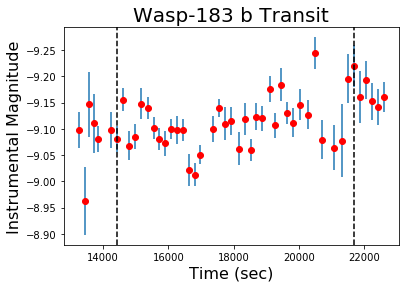

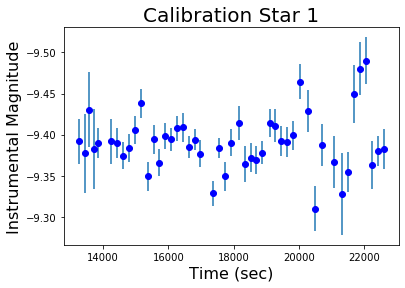

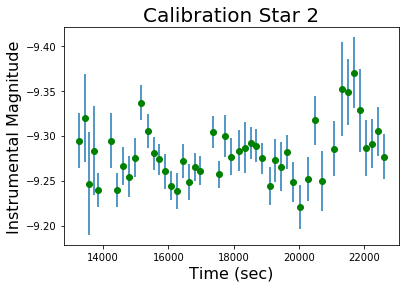

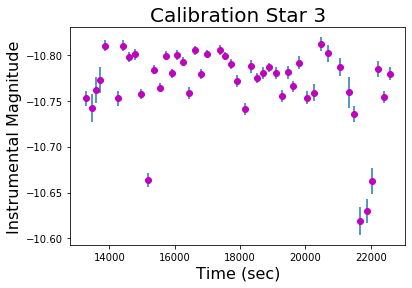

In [62]:
#differential photometry correction
mag_wasp=mag(master_flux_wasp)#target star magnitude
mag7=mag(master_flux_7)
mag13=mag(master_flux_13)
mag6=mag(master_flux_6)

#taking the initial difference in magnitudes using shot of index 3 as the comparison
diff7=mag7-mag7[3]
diff13=mag13-mag13[3]
diff6=mag6-mag6[3]

#taking the mean of the differences at each shot to create the differential photometry array
diff=[]
i=0
while i<len(mag7):
    diff.append(np.mean([diff7[i],diff13[i],diff6[i]]))
    i+=1

mag_wasp_corrected=mag_wasp-diff
mag7_corrected=mag7-diff
mag13_corrected=mag13-diff
mag6_corrected=mag6-diff


uncertaintywasp=[]
uncertainty7=[]
uncertainty13=[]
uncertainty6=[]
mag_wasp_err=[]
mag7_err=[]
mag13_err=[]
mag6_err=[]
#error propagation using the uncertainties package
x=0
while x<len(master_flux_wasp):
    uncertaintywasp.append(ufloat(master_flux_wasp[x],master_flux_wasp_err[x]))
    uncertainty7.append(ufloat(master_flux_7[x],master_flux_7_err[x]))
    uncertainty13.append(ufloat(master_flux_13[x],master_flux_13_err[x]))
    uncertainty6.append(ufloat(master_flux_6[x],master_flux_6_err[x]))
    uncertaintywasp[x]=-2.5*unumpy.log10(uncertaintywasp[x])
    uncertainty7[x]=-2.5*unumpy.log10(uncertainty7[x])
    uncertainty13[x]=-2.5*unumpy.log10(uncertainty13[x])
    uncertainty6[x]=-2.5*unumpy.log10(uncertainty6[x])
    mag_wasp_err.append(uncertaintywasp[x].std_dev)
    mag7_err.append(uncertainty7[x].std_dev)
    mag13_err.append(uncertainty13[x].std_dev)
    mag6_err.append(uncertainty6[x].std_dev)
    x+=1
        
#plotting
plt.plot(master_times,mag_wasp_corrected,'ro')
plt.errorbar(master_times,mag_wasp_corrected,yerr=mag_wasp_err, linestyle="none")
plt.title('Wasp-183 b Transit', fontsize=20)
plt.xlabel('Time (sec)',fontsize=16)
plt.ylabel('Instrumental Magnitude',fontsize=16)
plt.axvline(x=master_times[42], color='black', linestyle='dashed')
plt.axvline(x=master_times[6], color='black', linestyle='dashed')
plt.gca().invert_yaxis()
plt.savefig('wasp.png',bbox_inches='tight', dpi=300)
plt.show()

plt.plot(master_times,mag7_corrected,'bo')
plt.errorbar(master_times,mag7_corrected,yerr=mag7_err, linestyle="none")
plt.title('Calibration Star 1', fontsize=20)
plt.xlabel('Time (sec)', fontsize=16)
plt.ylabel('Instrumental Magnitude', fontsize=16)
plt.gca().invert_yaxis()
plt.savefig('target1.png',bbox_inches='tight', dpi=300)
plt.show()

plt.plot(master_times,mag13_corrected,'go')
plt.errorbar(master_times,mag13_corrected,yerr=mag13_err, linestyle="none")
plt.title('Calibration Star 2', fontsize=20)
plt.xlabel('Time (sec)', fontsize=16)
plt.ylabel('Instrumental Magnitude', fontsize=16)
plt.gca().invert_yaxis()
plt.savefig('target2.png',bbox_inches='tight', dpi=300)
plt.show()

plt.plot(master_times,mag6_corrected,'mo')
plt.errorbar(master_times,mag6_corrected,yerr=mag6_err, linestyle="none")
plt.title('Calibration Star 3', fontsize=20)
plt.xlabel('Time (sec)', fontsize=16)
plt.ylabel('Instrumental Magnitude', fontsize=16)
plt.gca().invert_yaxis()
plt.savefig('target3.png',bbox_inches='tight', dpi=300)
plt.show()

